# Recommender System - Exploratory Data Analysis

- **[Libraries](#lib)**
- **[Exploratory Data Analysis](#eda)**
    - **[1. Product](#pr)**
    - **[2. Countries](#cn)**
    - **[3. Time](#tm)**
    - **[4. Customers and Orders](#co)**

## Libraries
<a class="anchor"  id="lib" ></a>

In [114]:
# conventional libraries
import os
import calendar
import pandas as pd
import numpy as np

# data visualizations
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import seaborn as sns
import matplotlib.pyplot as plt

# algorithm
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [115]:
df = pd.read_csv("df_cleaned.csv")
df_negPQ = pd.read_csv("df_negqual.csv")

In [116]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.




## Exploratory Data Analysis
<a class="anchor"  id="eda" ></a>

In [117]:
temp = df[['CustomerID', 'InvoiceNo', 'StockCode']].groupby(['CustomerID', 'InvoiceNo', 'StockCode']).count()
temp = temp.reset_index(drop = False)
countries = temp['StockCode'].value_counts()
print('Number of products in ds: {}'.format(len(countries)))

Number of products in ds: 3659


In [118]:
temp = df[['CustomerID', 'InvoiceNo', 'Description']].groupby(['CustomerID', 'InvoiceNo', 'Description']).count()
temp = temp.reset_index(drop = False)
countries = temp['Description'].value_counts()
print('Number of products in ds: {}'.format(len(countries)))

Number of products in ds: 3871


In [119]:
temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Number of countries in ds: {}'.format(len(countries)))

Number of countries in ds: 37


In [120]:
print('Number of unique customers in ds: {}'.format(df.CustomerID.nunique()))

Number of unique customers in ds: 4333


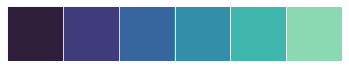

In [121]:
color = sns.color_palette("mako")
sns.palplot(color)

## Products
<a class="anchor"  id="pr" ></a>

### Q : What products are more popular ? 

In [122]:
df.groupby(['Description']).size().reset_index(name='counts').sort_values(by=['counts'],ascending=False).head()

,Description,counts
3692,white hanging heart t-light holder,2016
2761,regency cakestand 3 tier,1713
1760,jumbo bag red retrospot,1615
216,assorted colour bird ornament,1395
2340,party bunting,1389


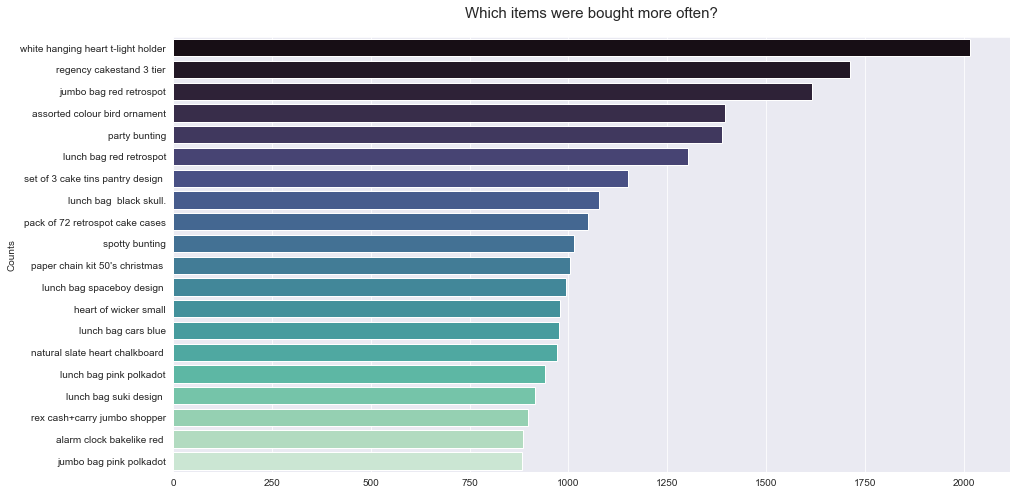

In [123]:
items = df['Description'].value_counts().head()
item_counts = df['Description'].value_counts().sort_values(ascending=False).head(20)
plt.figure(figsize=(15,8))
sns.barplot(y=item_counts.index, x=item_counts.values,palette = "mako")
plt.ylabel("Counts")
plt.title("Which items were bought more often?", fontsize=15,y=1.03);
plt.show()

In [124]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('Number of products', ascending=False)

,CustomerID,InvoiceNo,Number of products
5,12347,573511,47
0,12347,537626,31
1,12347,542237,29
2,12347,549222,24
4,12347,562032,22
3,12347,556201,18
7,12348,539318,16
6,12347,581180,11
8,12348,541998,5
9,12348,548955,4


## Countries
<a class="anchor"  id="cn" ></a>

### Q : Which countries bring the more sales ? 

In [125]:
#Top 5 countries sales count wise in the cleaned up data.
df.Country.value_counts().head()

United Kingdom    348885
Germany             8643
France              8019
EIRE                7126
Spain               2417
Name: Country, dtype: int64

In [126]:
#Top 5 countries Total Gross Amount sales wise.
data_temp = df.groupby(['Country'])['TotalPrice'].agg('sum').reset_index().sort_values(by=['TotalPrice'],ascending=False).head()
print(data_temp)

           Country    TotalPrice
35  United Kingdom  6.970138e+06
23     Netherlands  2.838893e+05
10            EIRE  2.570131e+05
14         Germany  2.053811e+05
13          France  1.838019e+05


In [127]:
sales_by_country = df.groupby(['Country']).TotalPrice.sum().sort_values(ascending = False).reset_index()
TotalSales = sales_by_country['TotalPrice'].sum()


sales_by_country['% of total sales'] = sales_by_country['TotalPrice']/TotalSales
#Top 5 countries by sales
sales_by_country.head()

,Country,TotalPrice,% of total sales
0,United Kingdom,6.970138e+06,0.823454
1,Netherlands,2.838893e+05,0.033539
2,EIRE,2.570131e+05,0.030364
3,Germany,2.053811e+05,0.024264
4,France,1.838019e+05,0.021714


In [128]:
import plotly.express as px

fig = px.pie(sales_by_country, values='% of total sales', names='Country',
             title='Distribution of Sales per Country',
             hover_data=['TotalPrice'],  color_discrete_sequence=px.colors.sequential.GnBu_r)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

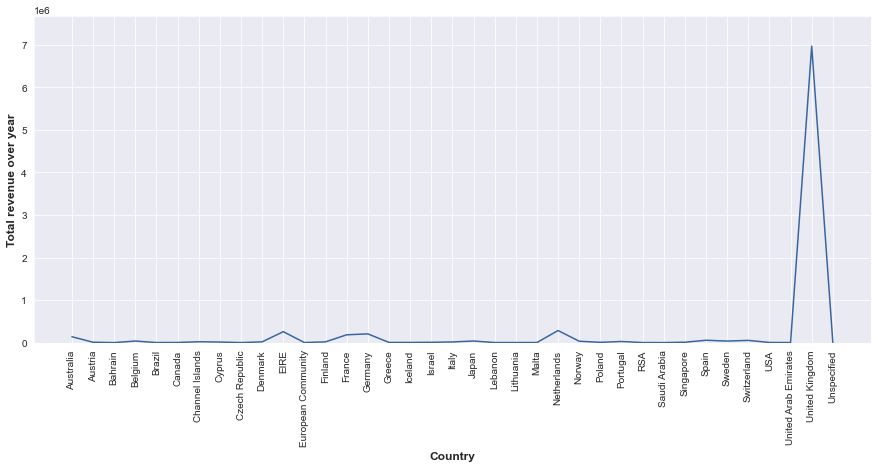

In [129]:
#exploratory statistics
plt.figure(figsize=(15,6))
temp  = df.groupby(['Country'])['TotalPrice'].apply(np.sum)
plt.plot(temp, color=color[2]);
plt.ylim(0,1.1*max(temp.values))
plt.ylabel('Total revenue over year',fontsize=12,fontweight='bold');
plt.xlabel('Country',fontsize=12,fontweight='bold');
plt.xticks(temp.index,temp.index,rotation=90)
plt.show()

Text(0, 0.5, 'Item')

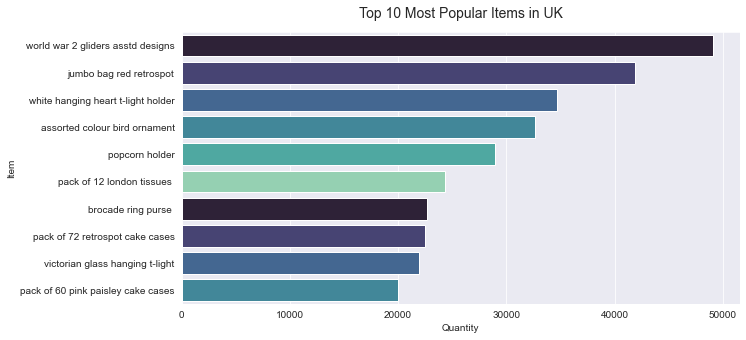

In [130]:
#Most Popular Product in UK 
indexed=df.pivot_table(index=['Country','StockCode','Description'], values='Quantity', aggfunc='sum').reset_index()

plt.figure(figsize=(10,5))
sns.barplot(y='Description', x='Quantity', data=indexed[indexed['Country']=='United Kingdom'].sort_values(by='Quantity', ascending=False).head(10),
           palette=color)
plt.title('Top 10 Most Popular Items in UK', fontsize=14,y=1.03)
plt.ylabel('Item')

From above plots and calculations we can see that vast majority of sales were made in UK and just 8.49% went abroad. We can say our dataset is skewed to the UK side. For the purpose of the analysis, the UK are exlcuded from the next visualizations.

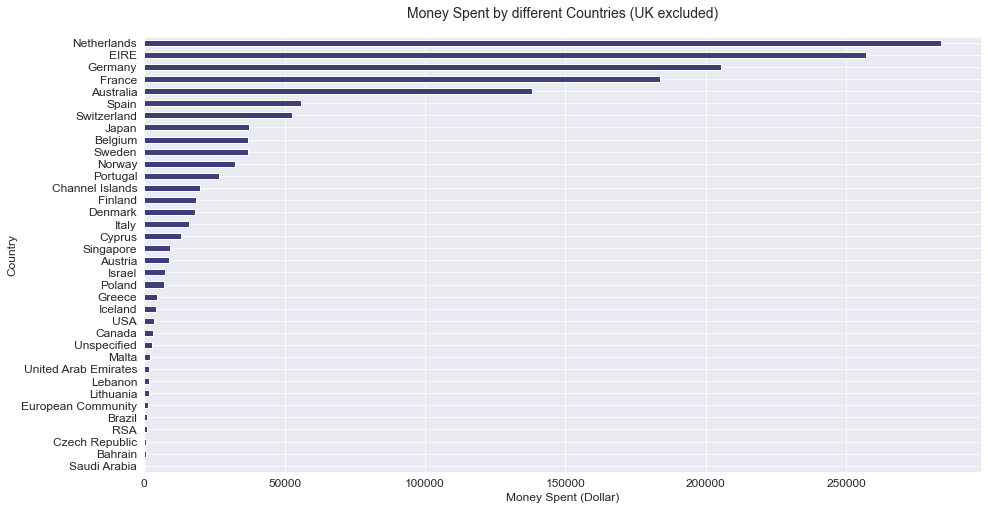

In [131]:
group_country_amount_spent = df.groupby('Country')['TotalPrice'].sum().sort_values()
del group_country_amount_spent['United Kingdom']

# plot total money spent by each country (without UK)
sns.set_style("darkgrid")
plt.subplots(figsize=(15,8))
group_country_amount_spent.plot(kind='barh', fontsize=12, color=color[1])
plt.xlabel('Money Spent (Dollar)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Money Spent by different Countries (UK excluded)', fontsize=14,y=1.03)
plt.show()

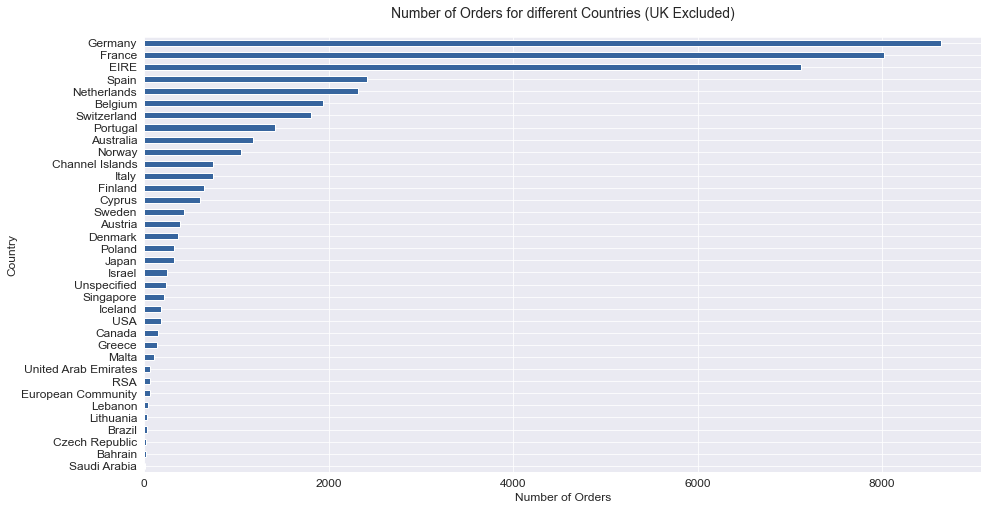

In [132]:
group_country_orders = df.groupby('Country')['InvoiceNo'].count().sort_values()
del group_country_orders['United Kingdom']

# plot number of unique customers in each country (without UK)
plt.subplots(figsize=(15,8))
group_country_orders.plot(kind='barh', fontsize=12, color=color[2])
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries (UK Excluded)', fontsize=14,y=1.03)
plt.show()

Even though the Netherlands are only the fourth country in Amount of Orders with a little more than 2100 orders,
they have the higher amount of sales 

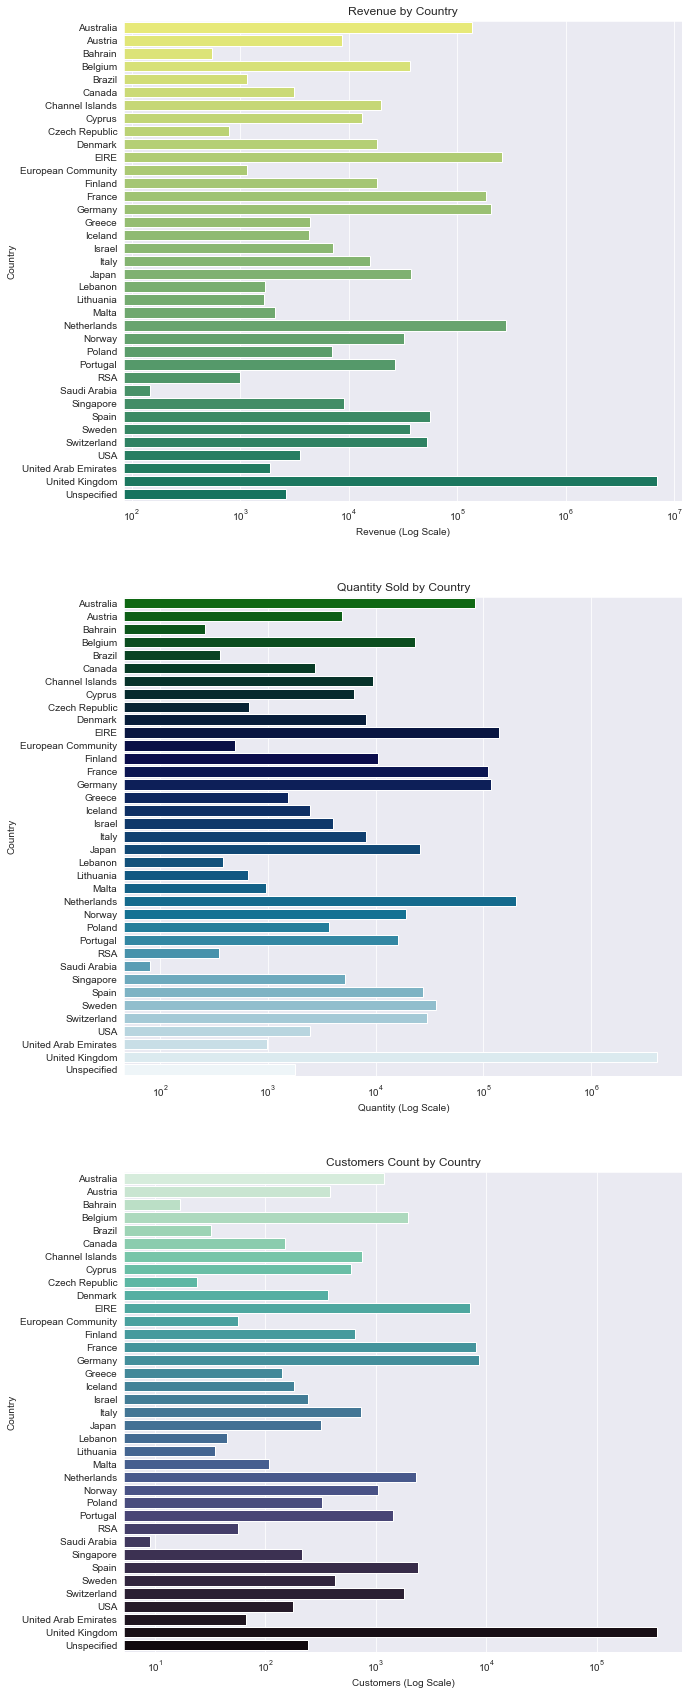

In [133]:
reg = df[df['TotalPrice']>=0].groupby('Country').agg({'TotalPrice':'sum',
                                                  'Quantity': 'sum',
                                                  'CustomerID': 'count'})

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,30))
g1 = sns.barplot(x=reg['TotalPrice'], y=reg.index, alpha=1, ax=ax[0],palette='summer_r', orient='h')
g2 = sns.barplot(x=reg['Quantity'], y=reg.index, alpha=1, ax=ax[1], palette='ocean',orient='h')
g3 = sns.barplot(x=reg['CustomerID'], y=reg.index, alpha=1, ax=ax[2], palette='mako_r', orient='h')
ax[2].title.set_text('Customers Count by Country')
ax[2].set_xlabel("Customers (Log Scale)")
ax[1].title.set_text('Quantity Sold by Country')
ax[1].set_xlabel("Quantity (Log Scale)")
ax[0].title.set_text('Revenue by Country')
ax[0].set_xlabel("Revenue (Log Scale)")
g1.set_xscale("log")
g2.set_xscale("log")
g3.set_xscale("log")
plt.show()

Since the given website is a United Kindom originated website. All the variables such as No. of Customers and the Gross total sales is dominated by the United Kingdom. The remaning portion is occupied by the neighbouring European Countries. 
* Top 5 countries in terms of highest counts of sale/invoices are: UK, Germany, France, Ireland, Spain.
* Top 5 countries in terms of Total Gross Amount sales are: UK, Netherlands, Ireland, Germany, France.



## Time
<a class="anchor"  id="tm" ></a>

### Q : How Many Orders Per Hour ? 

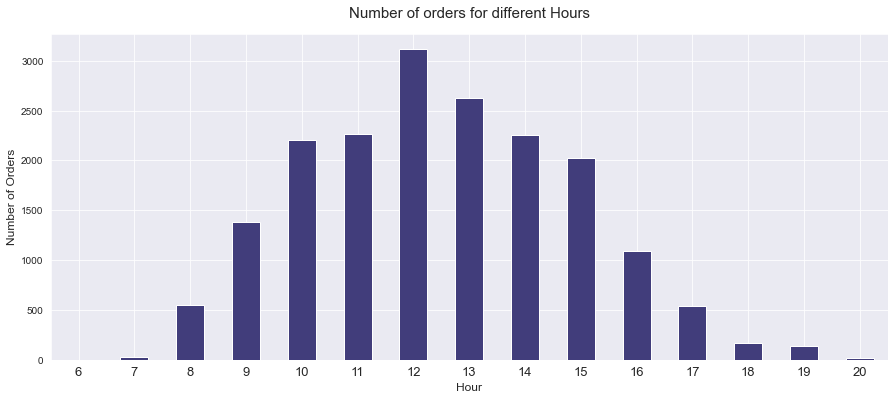

In [134]:
df.groupby('InvoiceNo')['Hour'].unique().value_counts().iloc[:-1].sort_index()

ax = df.groupby('InvoiceNo')['Hour'].unique().value_counts().iloc[:-1].sort_index().plot(kind='bar',
                                                                                         color=color[1],figsize=(15,6))
ax.set_xlabel('Hour',fontsize=12)
ax.set_ylabel('Number of Orders',fontsize=12)
ax.set_title('Number of orders for different Hours',fontsize=15, y=1.03)
ax.set_xticklabels(range(6,21), rotation='horizontal', fontsize=13)
plt.show()

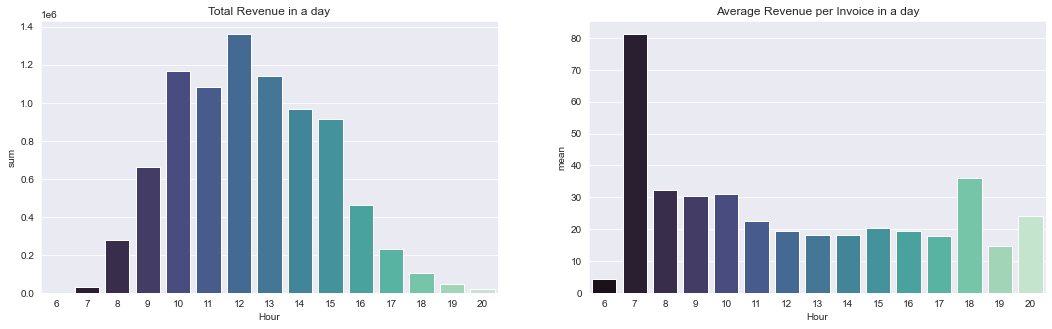

In [135]:
hour_sales = df.groupby(['Hour'])['TotalPrice'].agg(['sum','mean'])

sns.set_style("darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes = axes.flatten()

sns.barplot(x=hour_sales.index, y=hour_sales['sum'], ax=axes[0],
           palette="mako").set_title("Total Revenue in a day")
plt.ylabel('a')

sns.barplot(x=hour_sales.index, y=hour_sales['mean'], ax=axes[1], 
           palette="mako").set_title("Average Revenue per Invoice in a day")

plt.show()

#hour_sales

In [136]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

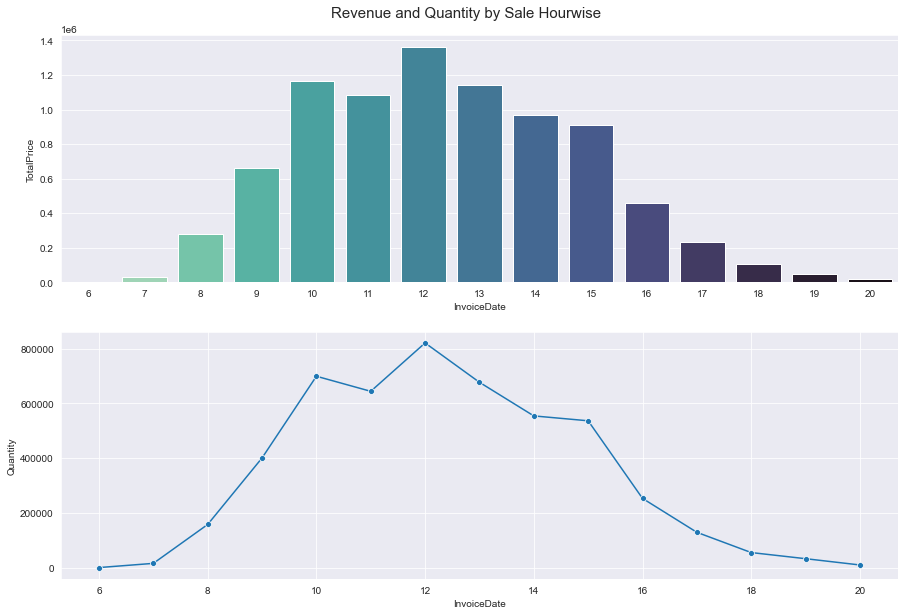

In [137]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,10))
sns.set_style("darkgrid")

day = df[df['TotalPrice']>=0][['InvoiceDate','TotalPrice','Quantity']]
day = day.groupby(day['InvoiceDate'].dt.hour)[['TotalPrice','Quantity']].sum()

sns.barplot(data = day, x=day.index, y='TotalPrice', alpha=1, ax=ax[0], palette="mako_r")
sns.lineplot(data = day, x=day.index, y='Quantity', marker='o', sort = False, ax=ax[1])
fig.suptitle('Revenue and Quantity by Sale Hourwise',fontsize=15,y=0.92)
#add_value_labels(ax[0])
plt.show()

What time do people tend to buy our products?
At 6 o'clock, people may want to return undesired stuff
Starting from 7 am, people tend to make purchase on the online retail. As we can see the revenue hit the top at 12pm. Afterwards, sales gradually decrease till 18pm. After that only a few of customers left make purchases.
Taking a look at the 2nd image, average revenue for an invoice at 7 am is substantially higher than the rest hours in a day. It suggests people make a huge quantity of items per transaction at the beginning of a day.

### Q : How Many Orders per Day ? 

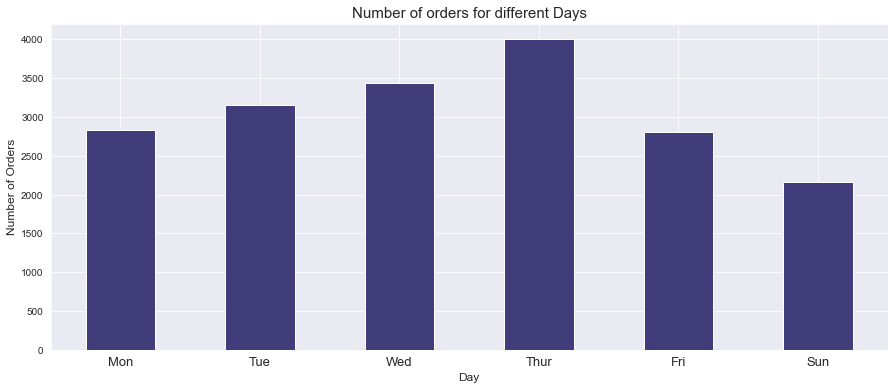

In [138]:
df.groupby('InvoiceNo')['weekday_nr'].unique().value_counts().sort_index()
ax = df.groupby('InvoiceNo')['weekday_nr'].unique().value_counts().sort_index().plot(kind='bar',color=color[1],figsize=(15,6))
ax.set_xlabel('Day',fontsize=12)
ax.set_ylabel('Number of Orders',fontsize=12)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=13)
plt.show()

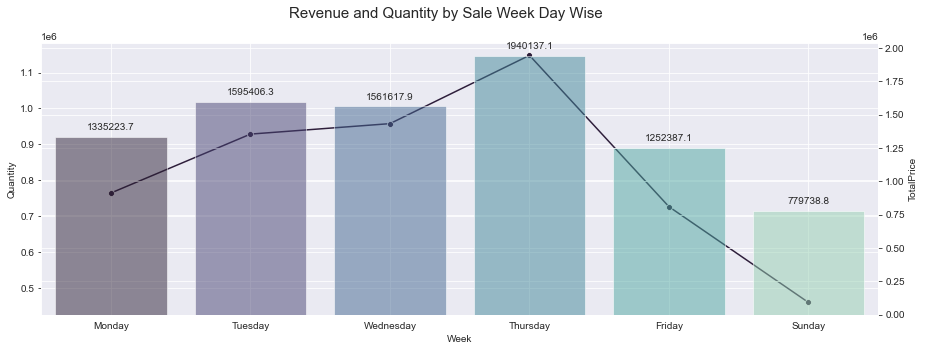

In [139]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,5))
sns.set_style("darkgrid")

week = df[df['TotalPrice']>=0][['InvoiceDate','TotalPrice','Quantity']]
week = week.groupby(week['InvoiceDate'].dt.weekday)[['TotalPrice','Quantity']].sum()
week = week.reset_index()
week['Week'] = week['InvoiceDate'].apply(lambda x: calendar.day_name[x])

sns.lineplot(data = week, x=week.Week, y='Quantity', marker='o', sort = False, ax=ax, color=color[0])
ax2 = ax.twinx()
sns.barplot(data = week, x=week.Week, y='TotalPrice', alpha=0.5, ax=ax2, palette='mako')
fig.suptitle('Revenue and Quantity by Sale Week Day Wise',fontsize=15)
add_value_labels(ax2)

plt.show()

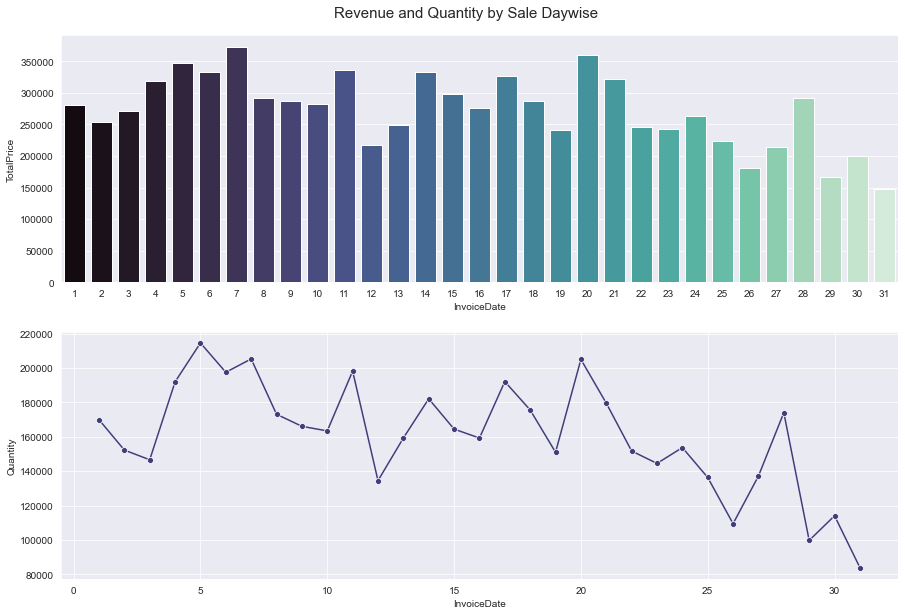

In [140]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,10))
sns.set_style("darkgrid")

date = df[df['TotalPrice']>=0][['InvoiceDate','TotalPrice','Quantity']]
date = date.groupby(date['InvoiceDate'].dt.day)[['TotalPrice','Quantity']].sum()

sns.barplot(data = date, x=date.index, y='TotalPrice', alpha=1, ax=ax[0], 
           palette="mako")
sns.lineplot(data = date, x=date.index, y='Quantity', marker='o', sort = False, ax=ax[1], color=color[1])
fig.suptitle('Revenue and Quantity by Sale Daywise',fontsize=15,y=0.92)

plt.show()

Customers tend to buy more at the beginning of month

### Q : How Many Orders per Month ?

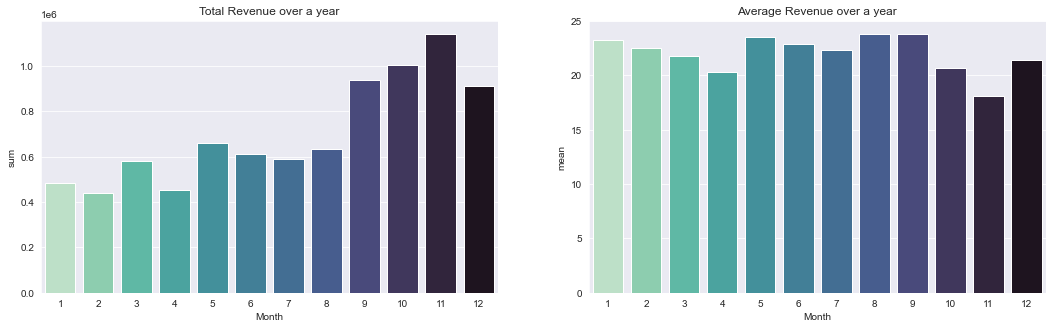

In [141]:
month_sales = df.groupby(['Month'])['TotalPrice'].agg(['sum','mean'])
sns.set_style("darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes = axes.flatten()

sns.barplot(x=month_sales.index, y=month_sales['sum'], ax=axes[0],
           palette="mako_r").set_title("Total Revenue over a year")
plt.ylabel('a')


sns.barplot(x=month_sales.index, y=month_sales['mean'], ax=axes[1],
           palette="mako_r").set_title("Average Revenue over a year")

plt.show()

#month_sales

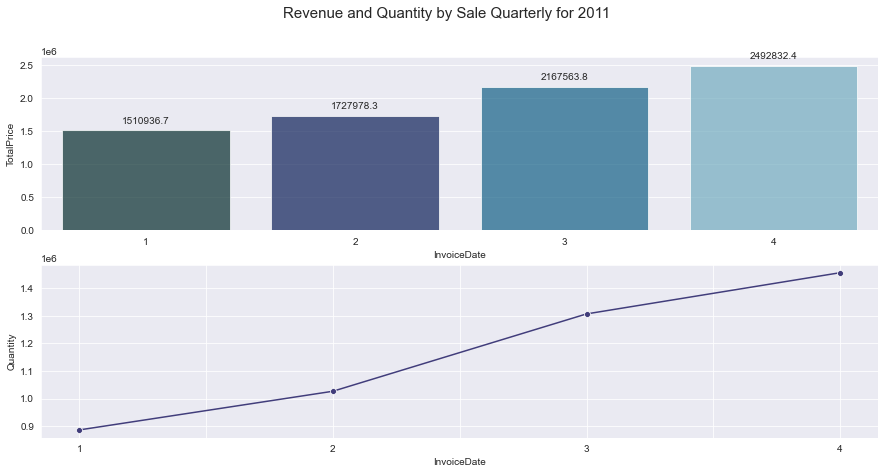

In [142]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))
sns.set_style("darkgrid")

q = df[(df['TotalPrice']>=0)&(df['InvoiceDate'].dt.year==2011)][['InvoiceDate','TotalPrice','Quantity']]
q = q.groupby(q['InvoiceDate'].dt.quarter)[['TotalPrice','Quantity']].sum()

sns.barplot(data = q, x=q.index, y='TotalPrice', alpha=0.7, ax=ax[0], palette = "ocean")
sns.lineplot(data = q, x=q.index, y='Quantity', marker='o', sort = False, ax=ax[1], color=color[1])
fig.suptitle('Revenue and Quantity by Sale Quarterly for 2011',fontsize=15)
add_value_labels(ax[0])
ax[1].set_xticklabels(['',1,'',2,'',3,'',4])
plt.show()

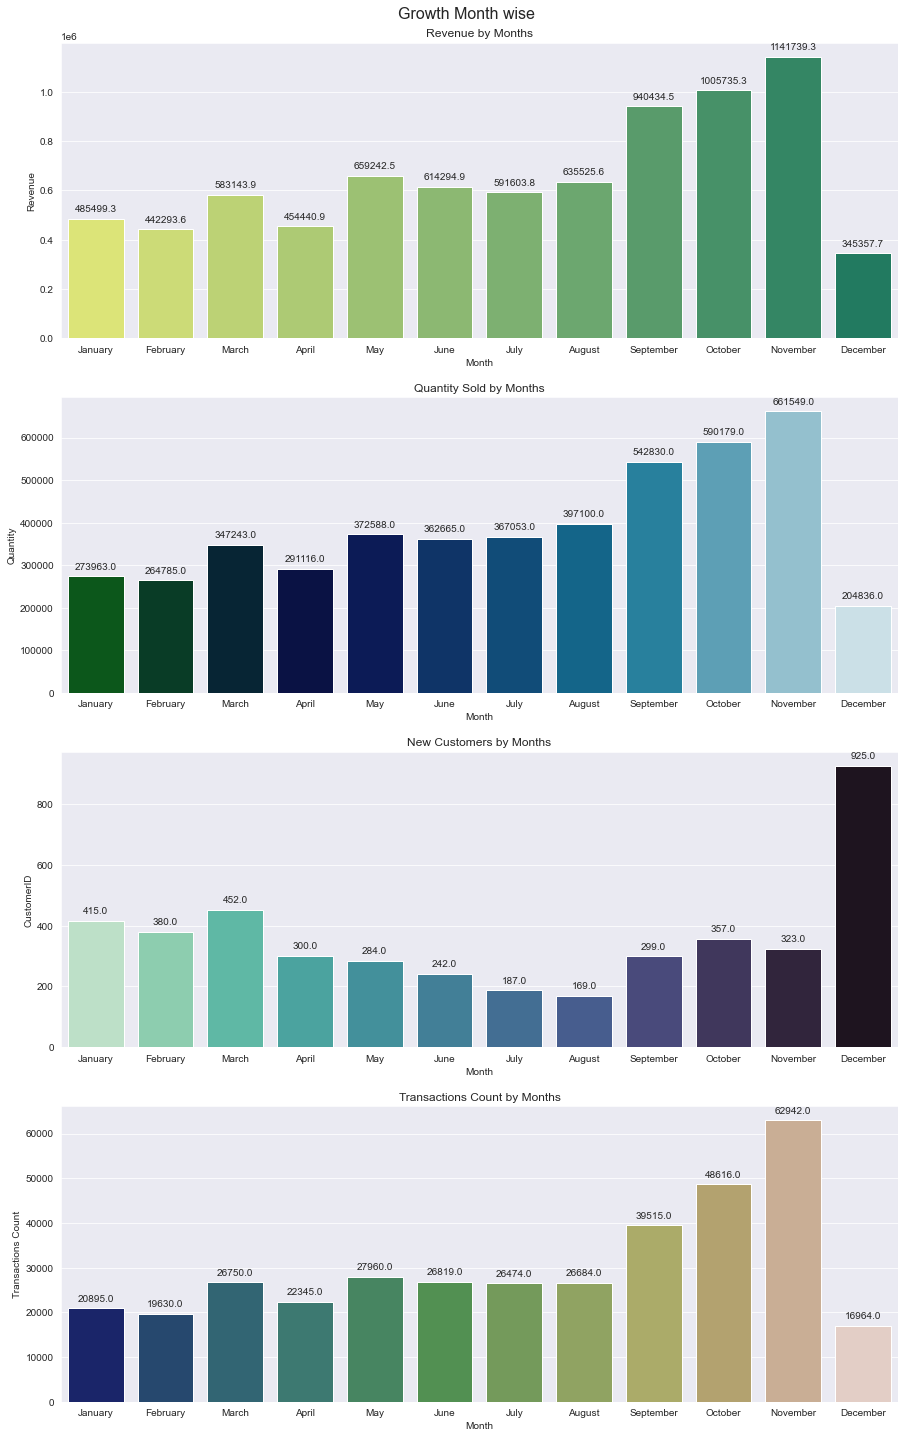

In [143]:
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,25))
rev = df[(df['TotalPrice']>0)&(df['InvoiceDate'].dt.year==2011)]
rev['Transactions Count'] = 1
rev = rev.groupby(rev['InvoiceDate'].dt.month).agg({'TotalPrice':'sum',
                                                  'Quantity': 'sum',
                                                  'CustomerID': 'count',
                                                'Transactions Count':'sum'})
rev = rev.reset_index()
rev['Month'] = rev['InvoiceDate'].apply(lambda x: calendar.month_name[x])
rev = rev.rename({'TotalPrice':'Revenue'},axis=1)
cust = df.groupby('CustomerID').first().reset_index()[['CustomerID','InvoiceDate']]
cust = cust.groupby(cust.InvoiceDate.dt.month).agg({'CustomerID':'count'})
cust = cust.reset_index()
cust['Month'] = cust['InvoiceDate'].apply(lambda x: calendar.month_name[x])


sns.set_style("darkgrid")
sns.barplot(data=rev, x=rev.Month, y='Revenue', palette='summer_r', ax=ax[0])
ax[0].title.set_text('Revenue by Months')
add_value_labels(ax[0])

sns.barplot(data=rev, x=rev.Month, y='Quantity',  palette='ocean', ax=ax[1])
ax[1].title.set_text('Quantity Sold by Months')
add_value_labels(ax[1])

sns.barplot(data=cust, x=cust.Month, y='CustomerID',  palette='mako_r', ax=ax[2])
ax[2].title.set_text('New Customers by Months')
fig.suptitle('Growth Month wise',fontsize=16)
add_value_labels(ax[2])

sns.barplot(data=rev, x=rev.Month, y='Transactions Count',  palette='gist_earth', ax=ax[3])
ax[3].title.set_text('Transactions Count by Months')
fig.suptitle('Growth Month wise',fontsize=16,y=0.90)
add_value_labels(ax[3])

plt.show()

Which month we sell out most and least?
As we see, from January to August, the revenue makes a gradual increase from $560K to $700K.
Towards the end of the year, sales make a huge jump to over a million and peak in November with $1461K
However, looking at average revenue diagram indicates nothing change drastically.

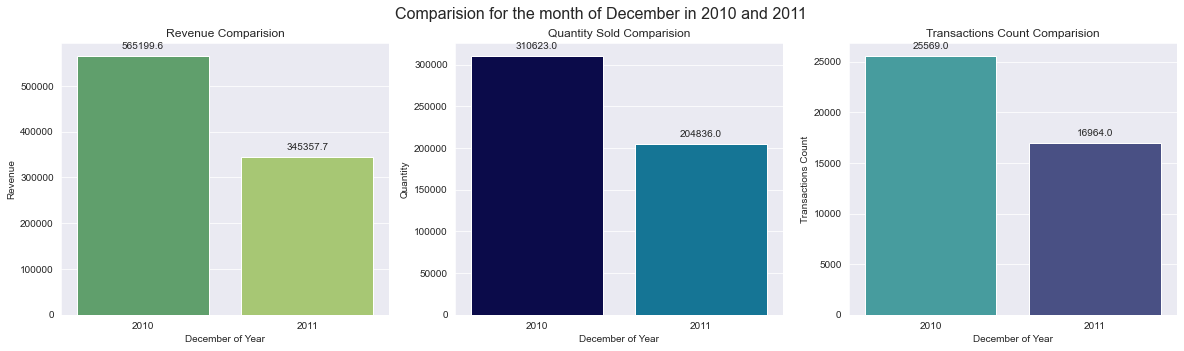

In [144]:
sales_comp = df[(df['InvoiceDate'].dt.month==12)&(df['TotalPrice']>=0)][['InvoiceDate','TotalPrice','Quantity']]
sales_comp['Transactions Count'] = 1
sales_comp = sales_comp.groupby(sales_comp['InvoiceDate'].dt.year)[['TotalPrice','Quantity','Transactions Count']].sum()
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,5))

sns.set_style("whitegrid")
sns.barplot(data=sales_comp, x=sales_comp.index, y='TotalPrice', palette='summer', ax=ax[0])
ax[0].title.set_text('Revenue Comparision')
ax[0].set_ylabel('Revenue')
ax[0].set_xlabel('December of Year')
add_value_labels(ax[0])

sns.barplot(data=sales_comp, x=sales_comp.index, y='Quantity',  palette='ocean', ax=ax[1])
ax[1].title.set_text('Quantity Sold Comparision')
add_value_labels(ax[1])
ax[1].set_xlabel('December of Year')

sns.barplot(data=sales_comp, x=sales_comp.index, y='Transactions Count',  palette='mako_r', ax=ax[2])
ax[2].title.set_text('Transactions Count Comparision')
add_value_labels(ax[2])
ax[2].set_xlabel('December of Year')

fig.suptitle('Comparision for the month of December in 2010 and 2011',fontsize=16)

plt.show()

### Overview 

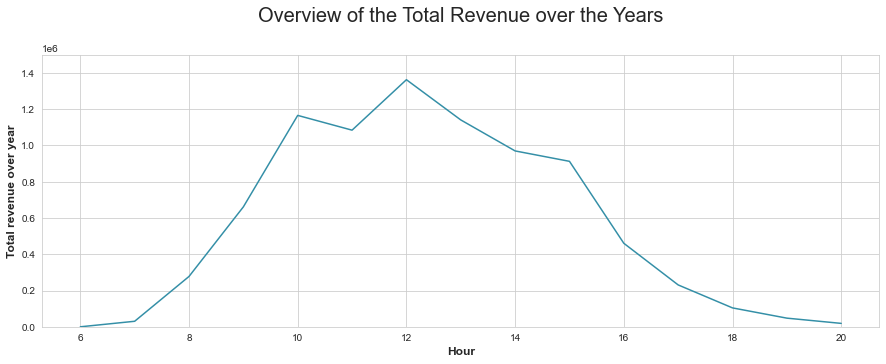

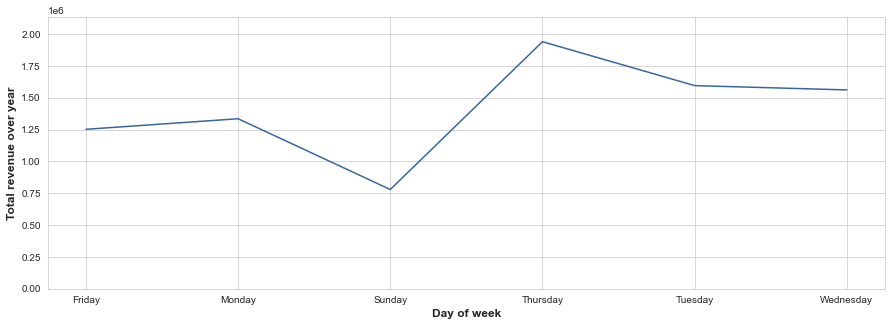

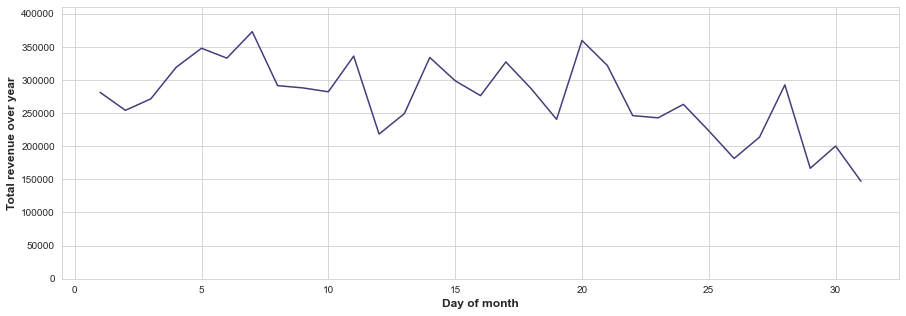

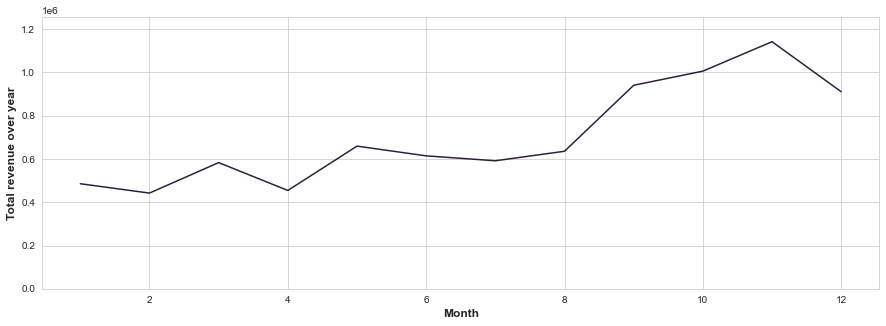

In [145]:

#exploratory statistics
plt.figure(figsize=(15,5))
temp  = df.groupby(['Hour'])['TotalPrice'].apply(np.sum)
plt.plot(temp, color=color[3]);
plt.ylim(0,1.1*max(temp.values))
plt.ylabel('Total revenue over year',fontsize=12,fontweight='bold');
plt.xlabel('Hour',fontsize=12,fontweight='bold');
plt.title("Overview of the Total Revenue over the Years", fontsize=20, y=1.10)
plt.show()

#exploratory statistics
plt.figure(figsize=(15,5))
temp  = df.groupby(['weekday'])['TotalPrice'].apply(np.sum)
plt.plot(temp,color=color[2]);
plt.ylim(0,1.1*max(temp.values))
plt.ylabel('Total revenue over year',fontsize=12,fontweight='bold');
plt.xlabel('Day of week',fontsize=12,fontweight='bold');
plt.show()

#exploratory statistics
plt.figure(figsize=(15,5))
temp  = df.groupby(['Day'])['TotalPrice'].apply(np.sum)
plt.plot(temp,color=color[1]);
plt.ylim(0,1.1*max(temp.values))
plt.ylabel('Total revenue over year',fontsize=12,fontweight='bold');
plt.xlabel('Day of month',fontsize=12,fontweight='bold');
plt.show()


#exploratory statistics
plt.figure(figsize=(15,5))
temp  = df.groupby(['Month'])['TotalPrice'].apply(np.sum)
plt.plot(temp,color=color[0])
plt.ylim(0,1.1*max(temp.values))
plt.ylabel('Total revenue over year',fontsize=12,fontweight='bold');
plt.xlabel('Month',fontsize=12,fontweight='bold');
plt.show()




Hourly sales are normally distributed and with mean 709k.
There is no pattern in day wise sales in a month.
There is no business on Saturday.
Average sales are consistent from Monday to Friday
Sales starts at 6 in the morning and ends at 8 PM.
Peak hours of sales are between 10 AM to 3 PM
Monday and Tuesday Sales starts at 7 AM and close at 6 PM
Wednesday and Friday sales start at 7 AM and close at 8 PM
Business hours for Sunday is between 9 to 4 PM

### Sales Trends

In [146]:
 # Same as after ? 
sales_by_date = df.groupby(by='Date')['Sales'].sum().reset_index()
fig = go.Figure(data=go.Scatter(x=sales_by_date.Date,y=sales_by_date.Sales
                                ,line = dict(color="#4b778d", width=1.5)))
fig.update_layout(xaxis_title="Date",yaxis_title="Sales",title='Daily Sales',template='ggplot2')
fig.show()

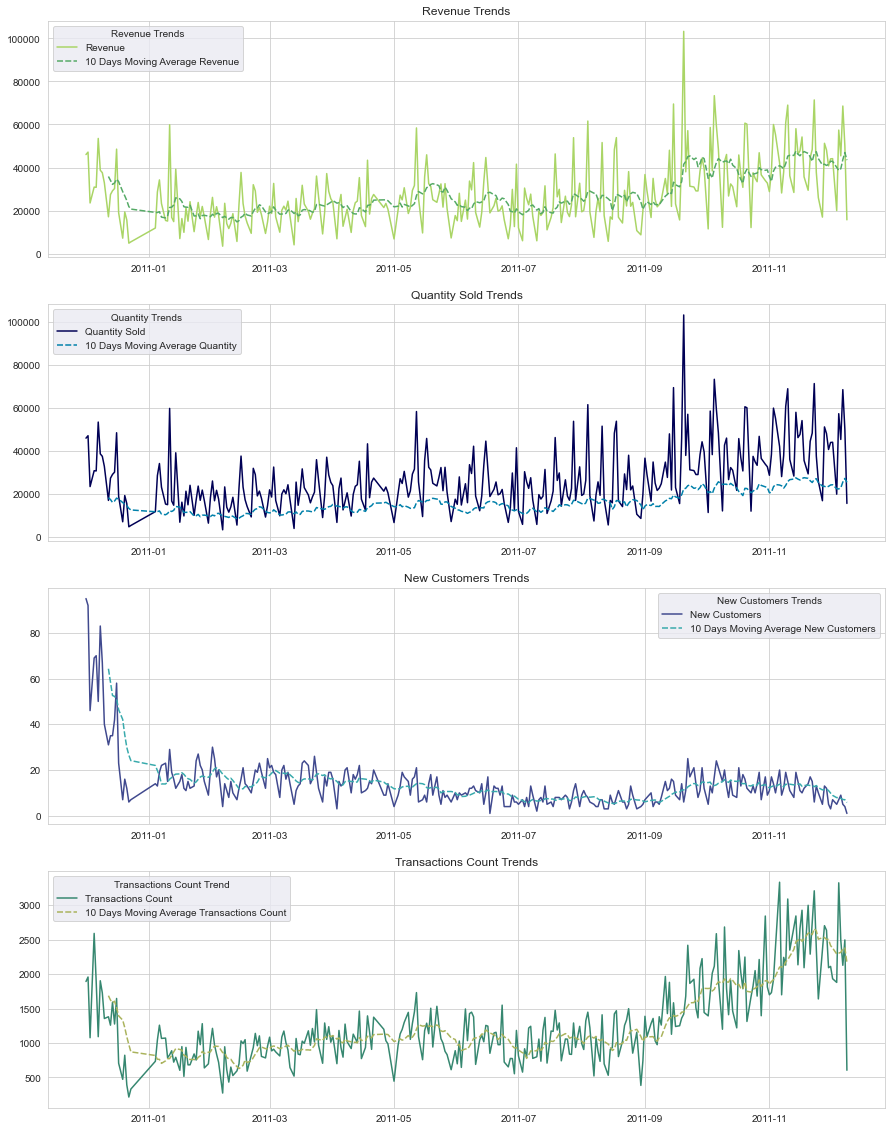

In [147]:
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,20))
rev = df[df['TotalPrice']>=0]
rev['TransactionsCount'] = 1
rev = rev.groupby(rev['InvoiceDate'].dt.date).agg({'TotalPrice':'sum',
                                                  'Quantity': 'sum',
                                                  'CustomerID': 'count',
                                                  'TransactionsCount':'sum'})
rev['10 Days Moving Average Revenue'] = rev['TotalPrice'].rolling(10).mean()
rev['10 Days Moving Average Quantity'] = rev['Quantity'].rolling(10).mean()
rev['10 Days Moving Transactions Count'] = rev['TransactionsCount'].rolling(10).mean()
cust = df.groupby('CustomerID').first().reset_index()[['CustomerID','InvoiceDate']]
cust = cust.groupby(cust.InvoiceDate.dt.date).agg({'CustomerID':'count'})
cust['10 Days Moving Average Quantity'] = cust['CustomerID'].rolling(10).mean()

sns.set_style("darkgrid")
sns.lineplot(data=rev[['TotalPrice','10 Days Moving Average Revenue']], palette='summer_r', linewidth=1.5, ax=ax[0],legend=False)
ax[0].legend(title='Revenue Trends', loc='upper left', labels=['Revenue', '10 Days Moving Average Revenue'])
ax[0].title.set_text('Revenue Trends')
ax[0].set_xlabel('')

sns.lineplot(data=rev[['TotalPrice','10 Days Moving Average Quantity']], palette='ocean', linewidth=1.5, ax=ax[1])
ax[1].legend(title='Quantity Trends', loc='upper left', labels=['Quantity Sold', '10 Days Moving Average Quantity'])
ax[1].title.set_text('Quantity Sold Trends')
ax[1].set_xlabel('')

sns.lineplot(data=cust, palette='mako', linewidth=1.5, ax=ax[2])
ax[2].legend(title='New Customers Trends', loc='upper right', labels=['New Customers', '10 Days Moving Average New Customers'])
ax[2].title.set_text('New Customers Trends')
ax[2].set_xlabel('')

sns.lineplot(data=rev[['TransactionsCount','10 Days Moving Transactions Count']], palette='gist_earth', linewidth=1.5, ax=ax[3])
ax[3].legend(title='Transactions Count Trend', loc='upper left', labels=['Transactions Count', '10 Days Moving Average Transactions Count'])
ax[3].title.set_text('Transactions Count Trends')
ax[3].set_xlabel('')

plt.show()

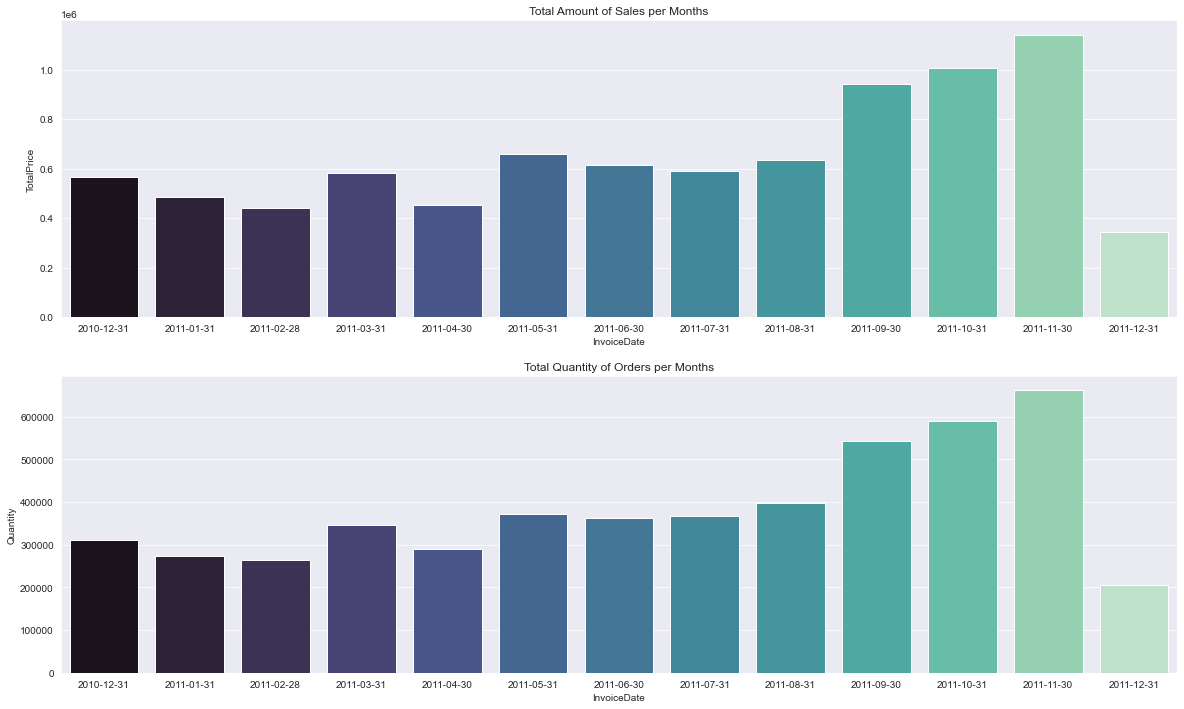

In [148]:
'''Convert InvoicdeDate to datetime'''
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

'''Grouping the data based on months to get a feel of the monthly sales data'''
data_new = df.groupby(pd.Grouper(key='InvoiceDate',freq='M')).sum()
data_new.reset_index(level=0, inplace=True)

fig, axs = plt.subplots(2, 1, figsize=(20,12))

sns.barplot(data=data_new, x='InvoiceDate', y='TotalPrice', palette="mako", ax=axs[0])
axs[0].title.set_text("Total Amount of Sales per Months")
axs[0].set_xticklabels(data_new.InvoiceDate.astype(str))

sns.barplot(data=data_new, x='InvoiceDate', y='Quantity', palette="mako", ax=axs[1])
axs[1].title.set_text("Total Quantity of Orders per Months")
axs[1].set_xticklabels(data_new.InvoiceDate.astype(str))
plt.show()

Thus, we conclude that Nov-2011 resulted in the highest sales both by TotalAmount and Quantity(this may be the case because of Christmas Shopping? ;) ), while Feb-2011 was the worst in terms of sales and the last quarter of the year was best among the 2011 quarters.

## Customers and Orders
<a class="anchor"  id="co" ></a>

### Q : Are there New Customers ? 

In [149]:
data = df.copy()

In [150]:
data["Customer"] = data["CustomerID"].apply(lambda x: 1 if x>1 else 0)

In [151]:
data.Customer.value_counts()

1    391163
Name: Customer, dtype: int64

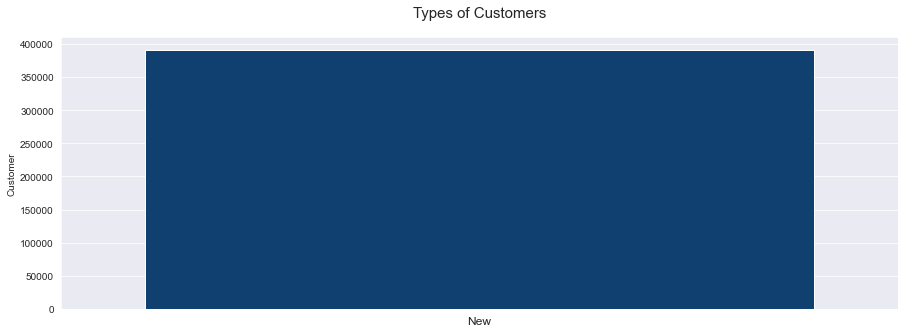

In [152]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,5))
sns.set_style("darkgrid")
sns.barplot(data=data, x=data.Customer.unique(), y=data.Customer.value_counts(),
            palette='ocean')
plt.title('Types of Customers', fontsize=15, y=1.05)
ax.set_xticklabels(['New', 'Old'], fontsize=12)
plt.show()

AOV :  460.0527637371606


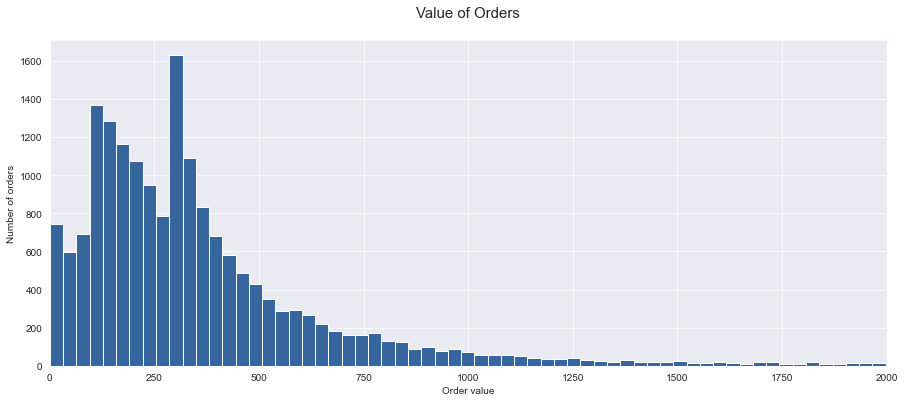

In [153]:
#Average per Order in EUR (AOV)

df_wt_cust = df[(df['CustomerID'].notnull()) & (df['Quantity']>0)]

order_net = df_wt_cust.groupby(['InvoiceNo']).TotalPrice.sum()
aov = order_net.mean()
plt.figure(figsize=(15,6))
plt.hist(order_net,bins=1000, color=color[2])
plt.xlim(0,2000)
plt.xlabel("Order value")
plt.ylabel("Number of orders")
plt.title("Value of Orders", fontsize=15, y=1.05)
print("AOV : ",aov)
plt.show()



The aov is 480. Next I'm going to find the %repeat customers.

From the last part, we learned that there're refunded orders, so I'll calculated number of orders per customer by count total orders and subtract by total refund order by each customer

%Repeat Customer :  65.26655896607431 %


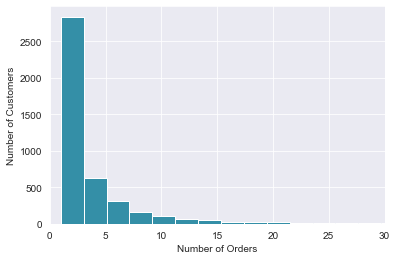

In [154]:
#Repeat Customers

#Exlude non-product rows

df_for_rpt_cust = df_wt_cust.copy()

cust_wt_total_order = df_for_rpt_cust[df_for_rpt_cust['TotalPrice']>0].groupby(['CustomerID']).InvoiceNo.nunique().reset_index()
cust_wt_total_order = cust_wt_total_order.rename(columns = {'InvoiceNo' : 'TotalOrder'})

cust_wt_total_refund_order = df_for_rpt_cust[df_for_rpt_cust['TotalPrice']<0].groupby(['CustomerID']).InvoiceNo.nunique().reset_index()
cust_wt_total_refund_order = cust_wt_total_refund_order.rename(columns = {'InvoiceNo' : 'TotalRefundOrder'})

join_cust_wt_total_order = cust_wt_total_order.merge(cust_wt_total_refund_order,left_on = 'CustomerID',right_on='CustomerID',how = 'left')
# convert null to 0
join_cust_wt_total_order['TotalRefundOrder'] = np.where(join_cust_wt_total_order['TotalRefundOrder'].isnull(),0,join_cust_wt_total_order['TotalRefundOrder'])
join_cust_wt_total_order['TotalSuccessOrder'] = join_cust_wt_total_order['TotalOrder']-join_cust_wt_total_order['TotalRefundOrder']

join_cust_wt_total_order['RepeatFlg'] = join_cust_wt_total_order['TotalSuccessOrder']>=2

CntCustomer = join_cust_wt_total_order.CustomerID.nunique()
CntRepeatCustomer = join_cust_wt_total_order[join_cust_wt_total_order['RepeatFlg']==True].CustomerID.nunique()
PctRepeatCustomer = CntRepeatCustomer/CntCustomer

print("%Repeat Customer : ",PctRepeatCustomer*100,"%")

plt.hist(join_cust_wt_total_order['TotalSuccessOrder'],bins = 100, color=color[3])
plt.xlim(0,30)
plt.xlabel("Number of Orders")
plt.ylabel("Number of Customers")
plt.show()

The percentage of repeated Customer is 65.5% which is pretty high and many customers keep coming back multiple times.

### Q : Which customer are likely to return a product ?

In [155]:
# remove outliers for Quantity
df_negPQ = df_negPQ[(df_negPQ['Quantity'] < 20000) & (df_negPQ['Quantity'] > -20000)]

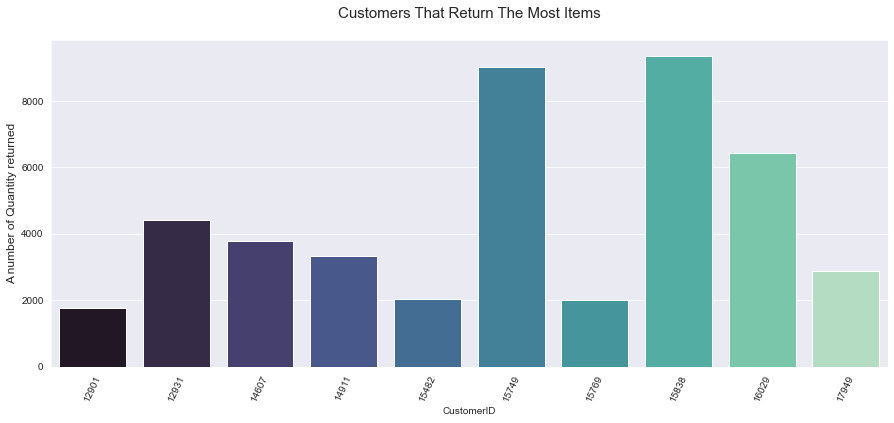

,TotalPrice,Quantity
,sum,sum
CustomerID,,
15838,-280.80,-9360
15749,-22998.40,-9014
16029,-12338.16,-6420
12931,-8511.15,-4427
14607,-5228.40,-3768
14911,-7393.59,-3331
17949,-4814.74,-2878
15482,-4486.24,-2022


In [156]:
Item_returned = df_negPQ[df_negPQ['Quantity'] < 0].groupby('CustomerID')[['TotalPrice',
                                              'Quantity']].agg(['sum']).sort_values(by=[('Quantity', 'sum')], ascending=True).head(10)

sns.set_style("darkgrid")
plt.figure(figsize=(15,6))
sns.barplot(x=Item_returned.index, y=abs(Item_returned[('Quantity','sum')]), palette="mako")
plt.ylabel('A number of Quantity returned', fontsize = 12)
plt.xticks(rotation=65)
plt.title("Customers That Return The Most Items", fontsize=15, y=1.05)
plt.show()

Item_returned

### Q : What are the Most Usual Orders ? 

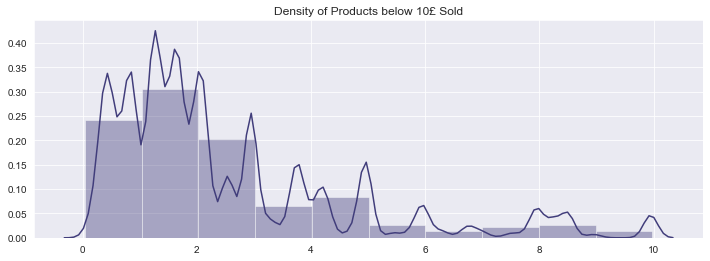

In [157]:
plt.figure(figsize=(12,4))
sns.distplot(df[df['UnitPrice'] < 10]['UnitPrice'].values, kde=True, bins=10, color=color[1])
plt.title("Density of Products below 10£ Sold")
plt.show()

From these histograms we can see that vast majority of items sold in this store has low price range - 0 to 3 pounds.

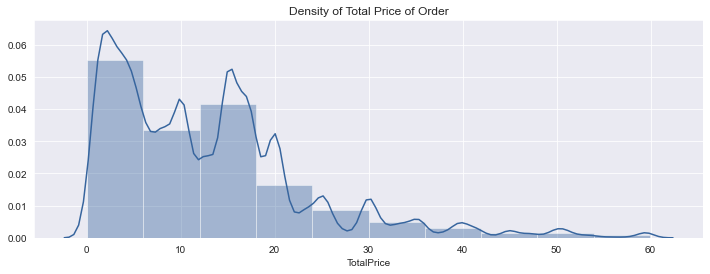

In [158]:
plt.figure(figsize=(12,4))
sns.distplot(df[df['TotalPrice'] < 60]['TotalPrice'], kde=True, bins=10, color=color[2])
plt.title("Density of Total Price of Order")
plt.show()

From these histograms we can understand that majority of sales per order were in range 1-15 pounds each.

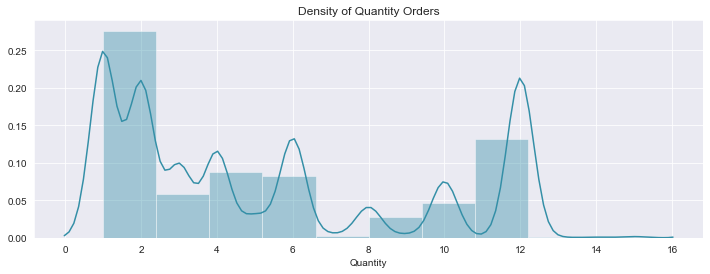

In [159]:
df_quantile_test = df.loc[((df['Quantity'] <= 15) & (df['Quantity'] > 0))]

plt.figure(figsize=(12,4))
sns.distplot(df_quantile_test['Quantity'], kde=True, bins=10, color=color[3])
plt.title("Density of Quantity Orders")
plt.show()
#& df_quantile['Quantity'] > 0

From these histograms we that people bought normally 1-5 items or 10-12

In [160]:
#returns cost 0.1%, so ignore first
data_TP_above0 = df[df['TotalPrice']>=0].reset_index(drop=True)

0 Top 0.01 percent of customers,3.0 percent of profit
4 Top 0.1 percent of customers,12.0 percent of profit
43 Top 1 percent of customers,31.0 percent of profit
86 Top 2 percent of customers,37.0 percent of profit
216 Top 5 percent of customers,49.0 percent of profit
433 Top 10 percent of customers,60.0 percent of profit
866 Top 20 percent of customers,74.0 percent of profit
2166 Top 50 percent of customers,92.0 percent of profit


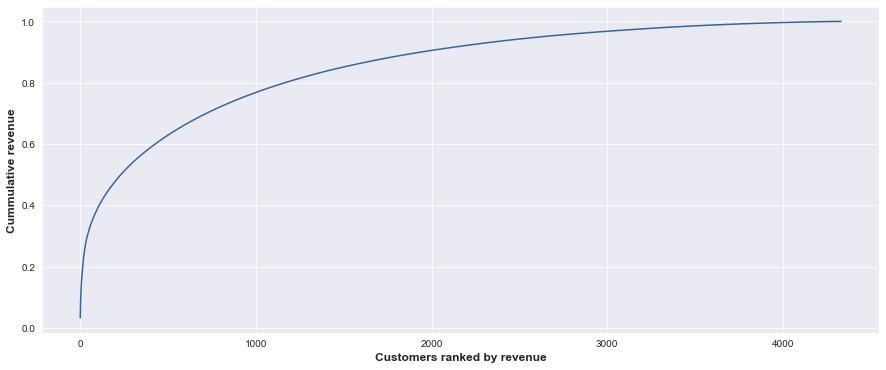

In [161]:
# are there any subgroups of important customer
temp = data_TP_above0.groupby(['CustomerID',])['TotalPrice'].apply(sum).reset_index(drop=False)
temp2 = temp.sort_values('TotalPrice').iloc[::-1].reset_index(drop=True)
result,val = [] ,0
for i in range(len(temp2)):
    val += temp2.iloc[i]['TotalPrice']
    result += [val,]
temp2['cummulative_profit'] = np.array(result)/val
for i in [0.01,0.1,1,2,5,10,20,50]:
    num = int(len(temp2)*1.*i/100)
    print (num,'Top %s percent of customers,%s percent of profit'%(i,100*np.round(temp2.loc[num]['cummulative_profit'],2)))
plt.figure(figsize=(15,6))
plt.plot(temp2['cummulative_profit'], color=color[2])
plt.xlabel('Customers ranked by revenue',fontsize=12,fontweight='bold')
plt.ylabel('Cummulative revenue',fontsize=12,fontweight='bold')
plt.show()

0 Top 0.01 percent of products,2.0 percent of profit
3 Top 0.1 percent of products,5.0 percent of profit
31 Top 1 percent of products,17.0 percent of profit
63 Top 2 percent of products,25.0 percent of profit
159 Top 5 percent of products,42.0 percent of profit
319 Top 10 percent of products,56.99999999999999 percent of profit
638 Top 20 percent of products,75.0 percent of profit
1597 Top 50 percent of products,95.0 percent of profit
1916 Top 60 percent of products,97.0 percent of profit


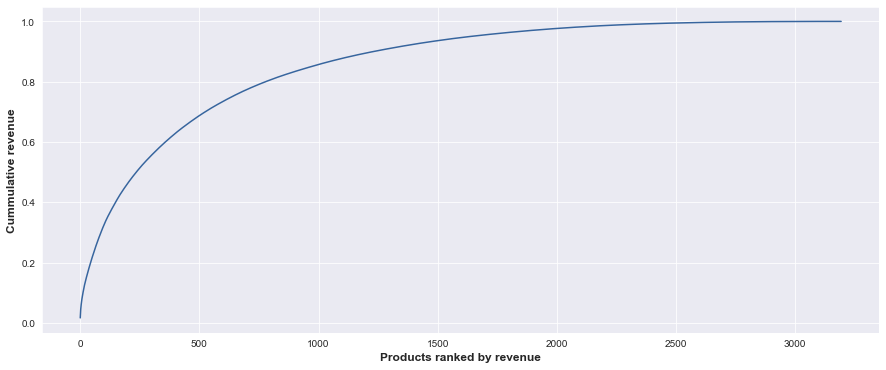

In [162]:
# are there any subgroups of important customer
temp = df.groupby(['StockCode_NR'])['TotalPrice'].apply(sum).reset_index(drop=False)
temp['totalRev_over_time'] = df.groupby(['StockCode_NR'])['TotalPrice'].apply(np.sum).reset_index(drop=True)
temp2 = temp.sort_values('totalRev_over_time').iloc[::-1].reset_index(drop=True)

result,val = [0,] ,0
for i in range(len(temp2)):
    val += temp2.iloc[i]['TotalPrice']
    result += [val,]
temp2['cummulative_profit'] = np.array(result[1:])/val
temp2['Total_profit'] = (np.array(result[1:])-np.array(result[:-1]))/val
for i in [0.01,0.1,1,2,5,10,20,50,60]:
    num = int(len(temp2)*1.*i/100)
    print (num,'Top %s percent of products,%s percent of profit'%(i,100*np.round(temp2.loc[num]['cummulative_profit'],2)))
plt.figure(figsize=(15,6))
plt.plot(temp2['cummulative_profit'], color=color[2])
x = 600 #coresponds to  97% products
#print (np.sum(temp2['totalRev_over_time']>x),'threshold=',x,',',np.round(np.mean(temp2['totalRev_over_time']>x),2),'of products account for',np.round(np.sum(temp2[temp2['totalRev_over_time']>x]['TotalRevenue'])/np.sum(temp2['TotalRevenue']),3),'of revenue\n\n')
temp3 = temp2[temp2['totalRev_over_time']>x]
data2 = pd.merge(df,temp3[['StockCode_NR','totalRev_over_time','Total_profit']]
         ,on='StockCode_NR',how='inner')
plt.xlabel('Products ranked by revenue',fontsize=12,fontweight='bold')
plt.ylabel('Cummulative revenue',fontsize=12,fontweight='bold')
plt.show()

## Bonus: calculate the percentage of new, active, inactive and return users in each month

In [163]:
# Calculate the number of new users, inactive users, return users and active users in each month
# Definition:
# New users: those who made their first purchase in the current month
# Active users: those who made purchases in the previous month and in the current month
# Inactive users: those who made purchases in previous months, but not in the current month
# Return users: those who made purchases before the previous month, not in the previous month and made purchases agian in the current month
df["InvoiceMonth"] = df["InvoiceDate"].apply(lambda x: x.replace(day=1))
df["InvoiceMonth"] = df["InvoiceMonth"].apply(lambda x: x.strftime("%Y-%m-%d"))
user_month_pivot = df.pivot_table(index=["CustomerID"], 
                                    columns=["InvoiceMonth"], 
                                    values=["InvoiceNo"], 
                                    aggfunc="count", 
                                    fill_value=0)
user_month_pivot.head()

InvoiceNo                                              \
InvoiceMonth 2010-12-01 2011-01-01 2011-02-01 2011-03-01 2011-04-01   
CustomerID                                                            
12347                31         29          0          0         24   
12348                16          5          0          0          4   
12349                 0          0          0          0          0   
12350                 0          0         16          0          0   
12352                 0          0         15         18          0   

                                                                     \
InvoiceMonth 2011-05-01 2011-06-01 2011-07-01 2011-08-01 2011-09-01   
CustomerID                                                            
12347                 0         18          0         22          0   
12348                 0          0          0          0          2   
12349                 0          0          0          0          0   
12350                 0          0          0          0          0   
12352                 0          0          0          0         30   

                                               
InvoiceMonth 2011-10-01 2011-11-01 2011-12-01  
CustomerID                                     
12347                47          0         11  
12348                 0          0          0  
12349                 0         72          0  
12350                 0          0          0  
12352                 0         14          0

In [164]:
# Replace count of invoices with 1
user_month_pivot = user_month_pivot.applymap(lambda x: 1 if x>0 else 0)
user_month_pivot.head()

InvoiceNo                                              \
InvoiceMonth 2010-12-01 2011-01-01 2011-02-01 2011-03-01 2011-04-01   
CustomerID                                                            
12347                 1          1          0          0          1   
12348                 1          1          0          0          1   
12349                 0          0          0          0          0   
12350                 0          0          1          0          0   
12352                 0          0          1          1          0   

                                                                     \
InvoiceMonth 2011-05-01 2011-06-01 2011-07-01 2011-08-01 2011-09-01   
CustomerID                                                            
12347                 0          1          0          1          0   
12348                 0          0          0          0          1   
12349                 0          0          0          0          0   
12350                 0          0          0          0          0   
12352                 0          0          0          0          1   

                                               
InvoiceMonth 2011-10-01 2011-11-01 2011-12-01  
CustomerID                                     
12347                 1          0          1  
12348                 0          0          0  
12349                 0          1          0  
12350                 0          0          0  
12352                 0          1          0

In [165]:
# Define functions to get user status
def user_status(data):
    status = []
    for i in range(13):
    # If the user has no purchase in the current month
        if data[i] == 0:
            # If the user has made purchases before
            if len(status) > 0:
                # If the user is unregistered in the previous month
                if status[i-1] == "unreg":
                # The the user is also unregistered this month
                    status.append("unreg")
                # Otherwise the user is an active user, i.e., he/she already registered
                else:
                    status.append("inactive")
            # Otherwise the user is not registered in the current month, i.e., he/she has never made any purchases
            else:
                status.append("unreg")
        else:
            # This is the first purchase of the user
            if len(status) == 0:
                status.append("new")
            else:
                if status[i-1] == "inactive":
                    status.append("return")
                elif status[i-1] == "unreg":
                    status.append("new")
                else:
                    status.append("active")
    return status

In [166]:
user_month_status = pd.DataFrame(user_month_pivot.apply(lambda x: pd.Series(user_status(x)), axis=1))
user_month_status.columns = user_month_pivot.columns
user_month_status.head()

InvoiceNo                                              \
InvoiceMonth 2010-12-01 2011-01-01 2011-02-01 2011-03-01 2011-04-01   
CustomerID                                                            
12347               new     active   inactive   inactive     return   
12348               new     active   inactive   inactive     return   
12349             unreg      unreg      unreg      unreg      unreg   
12350             unreg      unreg        new   inactive   inactive   
12352             unreg      unreg        new     active   inactive   

                                                                     \
InvoiceMonth 2011-05-01 2011-06-01 2011-07-01 2011-08-01 2011-09-01   
CustomerID                                                            
12347          inactive     return   inactive     return   inactive   
12348          inactive   inactive   inactive   inactive     return   
12349             unreg      unreg      unreg      unreg      unreg   
12350          inactive   inactive   inactive   inactive   inactive   
12352          inactive   inactive   inactive   inactive     return   

                                               
InvoiceMonth 2011-10-01 2011-11-01 2011-12-01  
CustomerID                                     
12347            return   inactive     return  
12348          inactive   inactive   inactive  
12349             unreg        new   inactive  
12350          inactive   inactive   inactive  
12352          inactive     return   inactive

In [167]:
month_status_pivot = pd.DataFrame(user_month_status.replace("unreg", np.NaN).apply(lambda x: pd.value_counts(x)))
month_status_pivot.head()

InvoiceNo                                              \
InvoiceMonth 2010-12-01 2011-01-01 2011-02-01 2011-03-01 2011-04-01   
active              NaN      323.0        260        290        301   
inactive            NaN      561.0        922       1158       1578   
new               884.0      415.0        380        452        300   
return              NaN        NaN        117        231        252   

                                                                     \
InvoiceMonth 2011-05-01 2011-06-01 2011-07-01 2011-08-01 2011-09-01   
active              366        410        365        386        423   
inactive           1661       1967       2198       2380       2353   
new                 284        242        187        169        299   
return              404        338        394        378        537   

                                               
InvoiceMonth 2011-10-01 2011-11-01 2011-12-01  
active              487        616        370  
inactive           2608       2632       3720  
new                 357        323         41  
return              517        721        202

In [168]:
month_status_pivot = month_status_pivot.fillna(0).T
month_status_pivot.reset_index(inplace=True)
month_status_pivot.set_index("InvoiceMonth", inplace=True)

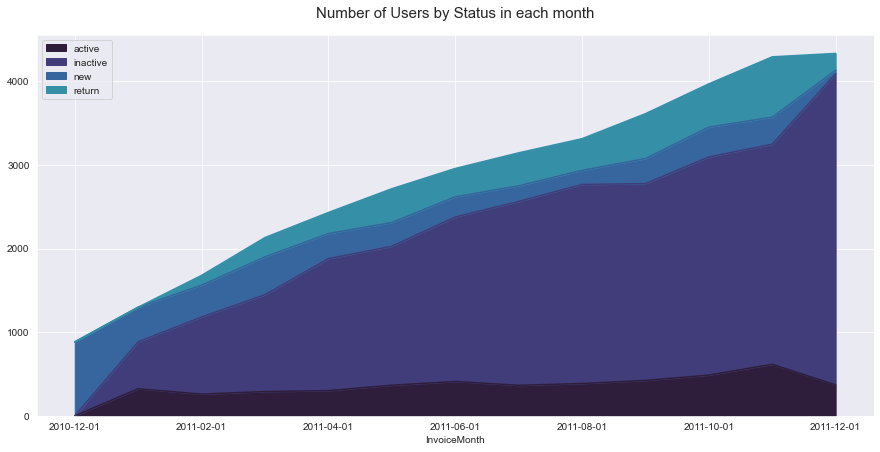

In [169]:
ax = month_status_pivot.plot.area(figsize = (15,7), color=color)
plt.title("Number of Users by Status in each month", fontsize=15, y=1.03)
plt.show()

### Same Analysis: 2010 vs. 2011